## 一、论文介绍

+ **[Non-Iterative, Feature-Preserving Mesh Smoothing](https://dl.acm.org/doi/abs/10.1145/1201775.882367)**

![image-20241224210505920](https://daetz-image.oss-cn-hangzhou.aliyuncs.com/img/202412242105005.png)





*We employ a spatial weight $f$ that depends on the distance $\|p - c_q  \|$between point $p$ and the centroid $c_q$ of region $q$. We also use an influence weight $g$ that depends on the distance $|| \Pi_q(p) - p \|$between the prediction and the original position of $p$. Finally, we weight by the area $a_q$ of the triangles to account for variations in the sampling rate of the surface. The estimate $p'$ for a point on surface $S$ is then:*

$$p' = \frac{1}{k(p)} \sum_{q \in S} \Pi_q(p) \, a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)$$

*where*

$$k(p) = \sum_{q \in S} a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)$$



我们采用的空间权重 $f$ 取决于 与 $q$的质心 $c_q$ 之间的距离 $|| p-c_q||$。我们还使用影响权重 $g$ ，该影响权重取决于预测与$p$的原始位置之间的距离 $||\Pi_q(p)−p∥$ 。最后，我们用三角形的面积 $a_q$ 来衡量表面采样率的变化。表面$S$上一点的估计 $p'$是

论文中的核心公式是（文中式(3)）：

$$
p' = \frac{1}{k(p)} \sum_{q \in S} \Pi_q(p) \, a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)
$$

其中

$$
k(p) = \sum_{q \in S} a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)
$$

*Gaussians are used both for the spatial weight f and for the in uence weight g inthis paper. Other robust in uence weightscould also beused, but Gaussians haveperformed wellinour experiments, aswellasthe work ofothers [Smith and Brady 1997; Tomasi and Manduchi1998; Durand and Dorsey 2002].*

*本文中的空间权重 f 和影响权重 g 都使用高斯函数。也可以使用其他强大的影响权重，但高斯模型在我们的实验以及其他人的工作中表现良好*



作者提到本文中的空间权重 $f$ 和影响权重 $g $都使用**高斯函数**，所以我们在后续也使用高斯函数

+ $p$ 表示当前顶点 (需要被去噪的那个顶点)

+ $p'$ 表示该顶点去噪后（或平滑后）的新位置

+ $q\in S$表示网格上的所有三角面片(或者在实际实现时，往往取“局部邻域”即可)

+ $\Pi_{q}(p)$表示将顶点 $p$ 投影到三角面片 $q$ 上得到的“预测点”(prediction)

+ $a_q$ 表示三角面片 $q$ 的面积，用来补偿采样不均匀(如果一些区域三角面片更密集，就相当于对该区域要稍加“削弱”或“平衡”)

+ $c_q$ 表示三角面片 $q$ 的质心(即该三角形三个顶点的平均位置)

+ $f(\| c_q - p \|)$称为空间权重(spatial weight)，主要控制“离得远的三角形面片”对当前顶点的贡献要小

+ $g(\|\Pi_{q}(p) - p\|)$ 称为影响权重(influence weight)，主要控制“预测点离原始位置很远时，该预测应被视为异常/outlier，贡献要小”

+ $k(p)$ 是所有权重之和，用来归一化，保证计算出来的 $p'$ 是某种加权平均结果。



### 1、顶点移动方向

在每次滤波时，该公式会对顶点 $p$ 进行一次更新，计算出一个新的位置 $p'$。

直观来看，$p'$ 相当于所有面片给出的预测点 $\Pi_{q}$ 的加权平均，而每个预测点根据“离 $p$ 的空间距离(由 $f$ 控制)”以及“预测点和原始位置差异(由 $g$ 控制)”来分配权重。

这样就意味着：如果某个三角面片 $q$ 对当前顶点做出的预测和 $p$ 差异过大，可能表示在尖锐特征处跨过了棱线，那么 $g$ 就会让这个预测权重变小，相当于**自动排斥跨越尖锐特征的“错误”平滑**。

整个过程并不是“朝法向方向”或“朝平面”的简单移动，而是“由多个邻居面片对顶点进行投影，然后再综合加权”得到一个新的位置。最终效果是：对噪声点进行平滑的同时又能较好地保留边缘或特征。



### 2、除三角外不需连通

*Filtering amesh involvesevaluating Equation (3) for every vertex and then moving them asagroup totheir estimated positions. Note that no connectivityisrequired beyond triangles: wesimply use the Euclidean distance tothe centroid ofsurrounding triangles to nd the spatial neighborhoodof avertex. Awider spatial  lter includes alarger number ofneigh bors inthe estimate, and can therefore removea greater amountofnoise, orsmo oth larger features. The in uence weightdetermines when the predictions ofneigh bors are considered outliers (byaccording them less weight), and therebycon trols the size offeatures that are preservedinthe  ltering.*

过滤网格涉及对每个顶点评估公式（3），然后将它们作为一个组移动到其估计位置。请注意，除了三角形之外，不需要连通性：我们只需使用到周围三角形质心的欧几里得距离来查找顶点的空间邻域。更宽的空间滤波器在估计中包含更多数量的邻居，因此可以去除更大量的噪声或平滑其他更大的特征。影响权重决定了邻居的预测何时被视为异常值（通过赋予它们较小的权重），从而控制过滤中保留的特征的大小。

这是指在实际操作中，我们只需要知道当前顶点 $p$的“**空间邻居**”可以由与之相邻的三角面片(或其质心)来确定。也就是说：

+ **只关心顶点周围出现的三角面**来构造空间邻域(找出周围面片的质心距离较近者)，不需要再去关心更复杂的网格拓扑(比如网格上更高级别的区域分段之类)。

+ 所以只要能找到每个三角面片的几何中心 $c_q$，并且能把顶点 $p$ 投影到该三角面片上 $\Pi_q(p)$，就可以进行权重计算并做加权平均。

+ “不需要额外连通”可以理解为，我们不需要一个全局的网格数据结构来进行大规模的遍历，只需要基于局部三角面的几何信息就够了。换句话说，“只要知道局部的三角形信息和它们之间的空间关系(比如质心、面积等)”，就能完成一轮更新。


## 二、代码介绍

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### 1、初始化$p$和$q$

+ $p$是需要处理的点
+ $q$泛指周围的三角
+ 我们在这里仅考虑周围的三个网格三角($q$) 对$p$进行网格去噪

In [14]:
# 定义原始顶点 p
p = np.array([1, 2, 1])
print(f"Original vertex p: {p}\n")

# 定义三角面片 q1, q2, q3，每个三角形由三个顶点组成
triangles = {
    'q1': {
        'vertices': np.array([[0, 0, 3],
                              [3, 0, 0],
                              [0, 3, 0]]),
    },
    'q2': {
        'vertices': np.array([[2, 1, 1],
                              [4, 1, 0],
                              [3, 2, 2]]),
    },
    'q3': {
        'vertices': np.array([[1, 4, 1],
                              [3, 5, 1],
                              [2, 2, 3]]),
    }
}    

Original vertex p: [1 2 1]



### 2、计算$a_q$和$c_q$

+ $a_q$表示各个网格三角的面积

+ $c_q$表示网格三角的质心

+ **质心计算公式**

  对于一个二维平面上的三角形，质心是该三角形三个顶点的坐标的**算术平均值**。设三角形的三个顶点坐标为 $(x_1, y_1), (x_2, y_2), (x_3, y_3)$那么三角形的质心 $(x_c,y_c)$ 的坐标可以通过以下公式计算：

  $x_c = \frac{x_1 + x_2 + x_3}{3}$

  $y_c = \frac{y_1 + y_2 + y_3}{3}$

In [15]:
# 计算每个三角形的平面方程、面积和质心
for key, tri in triangles.items():
    v1, v2, v3 = tri['vertices']
    
    # 计算平面法向量
    normal = np.cross(v2 - v1, v3 - v1)
    norm_length = np.linalg.norm(normal)
    normal_unit = normal / norm_length
    tri['normal'] = normal_unit
    
    # 计算平面方程常数项 c (n·v = c)
    c = np.dot(normal_unit, v1)
    tri['plane_eq'] = f"{normal_unit[0]:.2f}x + {normal_unit[1]:.2f}y + {normal_unit[2]:.2f}z = {c:.2f}"
    
    # 计算面积 (1/2 * |n|)
    area = 0.5 * norm_length
    tri['area'] = area
    
    # 计算质心
    centroid = (v1 + v2 + v3) / 3
    tri['centroid'] = centroid
    
    print(f"Triangle {key}:")
    print(f"  Vertices:\n{tri['vertices']}")
    print(f"  Plane equation: {tri['plane_eq']}")
    print(f"  Area: {tri['area']:.4f}")
    print(f"  Centroid: {tri['centroid']}\n")

Triangle q1:
  Vertices:
[[0 0 3]
 [3 0 0]
 [0 3 0]]
  Plane equation: 0.58x + 0.58y + 0.58z = 1.73
  Area: 7.7942
  Centroid: [1. 1. 1.]

Triangle q2:
  Vertices:
[[2 1 1]
 [4 1 0]
 [3 2 2]]
  Plane equation: 0.27x + -0.80y + 0.53z = 0.27
  Area: 1.8708
  Centroid: [3.         1.33333333 1.        ]

Triangle q3:
  Vertices:
[[1 4 1]
 [3 5 1]
 [2 2 3]]
  Plane equation: 0.30x + -0.60y + -0.75z = -2.83
  Area: 3.3541
  Centroid: [2.         3.66666667 1.66666667]



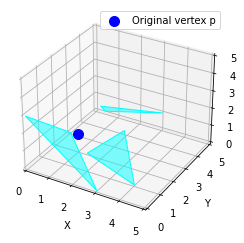

In [12]:
# 绘制图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三角面片
for key, tri in triangles.items():
    v1, v2, v3 = tri['vertices']
    verts = [v1, v2, v3]
    ax.add_collection3d(Poly3DCollection([verts], color='cyan', linewidths=1, edgecolors='r', alpha=0.5))

# 绘制原始顶点 p
ax.scatter(p[0], p[1], p[2], color='b', label='Original vertex p', s=100)

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图像的显示范围
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])

# 显示图例
ax.legend()

# 显示图像
plt.show()

### 3、计算$p$的$\Pi_q(p)$

+ $\Pi_q(p)$ 用于表示原点$p$在各个面$q$上的投影点


Calculating projections Πq(p):
Projection Πq1(p): [0.66548263 1.66548263 0.66548263]
Projection Πq2(p): [1.28644625 1.14066125 1.5728925 ]
Projection Πq3(p): [0.64514591 2.70970819 1.88713524]


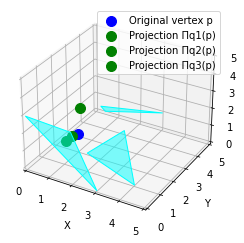

In [3]:
def project_point_to_plane(p, normal_unit, c):
    """
    投影点 p 到平面上。
    plane_eq: n·v = c
    normal_unit: 平面的单位法向量 n
    c: 平面方程常数项
    """
    distance = np.dot(normal_unit, p) - c
    projection = p - distance * normal_unit
    return projection
# 修正投影点计算
projections = {}
print("\nCalculating projections Πq(p):")
for key, tri in triangles.items():
    # 从平面方程字符串中提取常数项 c 并转换为浮点数
    c_str = tri['plane_eq'].split('=')[1].strip()
    try:
        c = float(c_str)
    except ValueError:
        print(f"Error: Cannot convert '{c_str}' to float for triangle {key}.")
        continue
    proj = project_point_to_plane(p, tri['normal'], c)
    projections[key] = proj
    print(f"Projection Π{key}(p): {proj}")

# 绘制图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三角面片
for key, tri in triangles.items():
    v1, v2, v3 = tri['vertices']
    verts = [v1, v2, v3]
    ax.add_collection3d(Poly3DCollection([verts], color='cyan', linewidths=1, edgecolors='r', alpha=0.5))

# 绘制原始顶点 p
ax.scatter(p[0], p[1], p[2], color='b', label='Original vertex p', s=100)

# 绘制投影点
for key, proj in projections.items():
    ax.scatter(proj[0], proj[1], proj[2], color='g', label=f'Projection Π{key}(p)', s=100)

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图像的显示范围
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])

# 显示图例
ax.legend()

# 显示图像
plt.show()

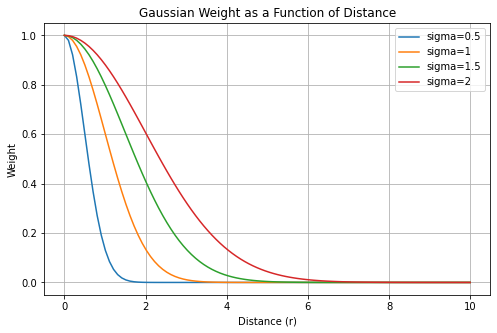

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_weight(r, sigma):
    return np.exp(- (r ** 2) / (2 * sigma ** 2))

# Generate values of r from 0 to 10
r = np.linspace(0, 10, 100)

# Different values of sigma
sigmas = [0.5, 1, 1.5, 2]

# Plot Gaussian weights for each sigma
plt.figure(figsize=(8, 5))
for sigma in sigmas:
    plt.plot(r, gaussian_weight(r, sigma), label=f'sigma={sigma}')

plt.title('Gaussian Weight as a Function of Distance')
plt.xlabel('Distance (r)')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.show()


### 4、计算空间权重$ f(r)$

+ $ f(r)= f(\| c_q - p \|)$ 表示的是质心$c_q$ 与原点$q$的距离在高斯函数下得到权重

In [4]:
# 定义高斯核函数
def gaussian_weight(r, sigma):
    return np.exp(- (r ** 2) / (2 * sigma ** 2))
# 参数
sigma_f = 1

# 计算空间权重 f(r)
f_weights = {}
print("\nCalculating spatial weights f(r):\n")
for key, tri in triangles.items():
    r = np.linalg.norm(tri['centroid'] - p)
    f = gaussian_weight(r, sigma_f)
    f_weights[key] = f
    print(f"f(||c{key} - p|| = {r:.3f}) = {f:.4f}")



Calculating spatial weights f(r):

f(||cq1 - p|| = 1.000) = 0.6065
f(||cq2 - p|| = 2.108) = 0.1084
f(||cq3 - p|| = 2.055) = 0.1211


Original vertex p: [1 2 1]



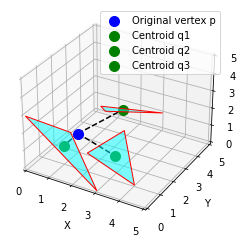

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 原始顶点
p = np.array([1, 2, 1])
print(f"Original vertex p: {p}\n")


# 绘制图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三角面片
for key, tri in triangles.items():
    verts = [list(tri['vertices'])]
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5))

# 绘制原始顶点 p
ax.scatter(*p, color='blue', s=100, label='Original vertex p')

# 绘制质心并连接 p 和质心
for key, tri in triangles.items():
    centroid = tri['centroid']
    ax.scatter(*centroid, color='green', s=100, label=f'Centroid {key}')
    ax.plot([p[0], centroid[0]], [p[1], centroid[1]], [p[2], centroid[2]], 'k--')  # 连接线

# 设置坐标轴标签和图例
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# 设置图像显示范围
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])

# 显示图像
plt.show()


### 5、计算影响权重$g(Δ)$

+ $g(Δ)= g(\|\Pi_{q}(p) - p\|)$ 表示的是原点$p$对于$\Pi_{q}(p)$的距离使用高斯函数得到权重
+ 距离越近，权重越高，对$p'$的贡献越大

+ 当出现预测点离原始位置很远时，该预测应被视为异常/outlier，贡献要小

In [6]:
# 定义影响权重参数
sigma_g = 1
# 计算影响权重 g(Δ)
g_weights = {}
print("\nCalculating influence weights g(Δ):\n")
for key, proj in projections.items():
    delta = np.linalg.norm(proj - p)
    g = gaussian_weight(delta, sigma_g)
    g_weights[key] = g
    print(f"g(||Π{key}(p) - p|| = {delta:.3f}) = {g:.4f}")



Calculating influence weights g(Δ):

g(||Πq1(p) - p|| = 0.579) = 0.8455
g(||Πq2(p) - p|| = 1.072) = 0.5631
g(||Πq3(p) - p|| = 1.190) = 0.4925


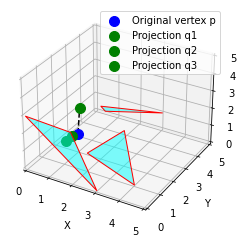

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# 计算投影点的函数
def project_point_to_plane(p, normal_unit, c):
    distance = np.dot(normal_unit, p) - c
    projection = p - distance * normal_unit
    return projection

# 计算投影点并存储
projections = {}
for key, tri in triangles.items():
    v1, v2, v3 = tri['vertices']
    normal = np.cross(v2 - v1, v3 - v1)
    normal_unit = normal / np.linalg.norm(normal)
    c = np.dot(normal_unit, v1)
    projections[key] = project_point_to_plane(p, normal_unit, c)

# 绘制图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三角面片
for key, tri in triangles.items():
    verts = [list(tri['vertices'])]
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5))

# 绘制原始顶点 p
ax.scatter(*p, color='blue', s=100, label='Original vertex p')

# 绘制投影点并连接到 p
for key, proj in projections.items():
    ax.scatter(*proj, color='green', s=100, label=f'Projection {key}')
    ax.plot([p[0], proj[0]], [p[1], proj[1]], [p[2], proj[2]], 'k--')

# 设置坐标轴标签和图例
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# 设置图像显示范围
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])

# 显示图像
plt.show()


### 6、计算$k(p)$

+ $k(p) = \sum_{q \in S} a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)$
+ $k(p_1)=a_{q_1} \times f(r_1) \times g(Δ_1)$
+ $k(p)=k(p_1)+k(p_2)+k(p_3)$
+ 也就表示三个平面的权重之和，用来归一化，保证计算出来的 $p'$ 是加权平均结果。


In [8]:
# 计算综合权重 wq 和 k(p)
wq = {}
k_p = 0
print("\nCalculating combined weights wq and k(p):\n")
for key in triangles.keys():
    w = triangles[key]['area'] * f_weights[key] * g_weights[key]
    wq[key] = w
    k_p += w
    print(f"w{key} = a{key} * f(r) * g(Δ) = {triangles[key]['area']} * {f_weights[key]:.4f} * {g_weights[key]:.4f} ≈ {w:.4f}")

print(f"\nk(p) = wq1 + wq2 + wq3 ≈ {k_p:.4f}\n")



Calculating combined weights wq and k(p):

wq1 = aq1 * f(r) * g(Δ) = 7.794228634059948 * 0.6065 * 0.8455 ≈ 3.9969
wq2 = aq2 * f(r) * g(Δ) = 1.8708286933869707 * 0.1084 * 0.5631 ≈ 0.1142
wq3 = aq3 * f(r) * g(Δ) = 3.3541019662496847 * 0.1211 * 0.4925 ≈ 0.2000

k(p) = wq1 + wq2 + wq3 ≈ 4.3111



### 7、计算$p'$

+ $p' = \frac{1}{k(p)} \sum_{q \in S} \Pi_q(p) \, a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)$区别与$k(p) = \sum_{q \in S} a_q \, f\left( \| c_q - p \| \right) \, g\left( \| \Pi_q(p) - p \| \right)$在于多了一个$\Pi_q(p)$也就是投影点

In [9]:
# 计算加权后的坐标
numerator = np.zeros(3)
print("Calculating weighted sum for new position p':\n")
for key in triangles.keys():
    weighted_proj = wq[key] * projections[key]
    numerator += weighted_proj
    print(f"w{key} * Π{key}(p) = {wq[key]:.4f} * {projections[key]} = {weighted_proj}")

p_prime = numerator / k_p
print(f"\nNew vertex position p' = {p_prime}\n")


Calculating weighted sum for new position p':

wq1 * Πq1(p) = 3.9969 * [0.66666667 1.66666667 0.66666667] = [2.66463111 6.66157778 2.66463111]
wq2 * Πq2(p) = 0.1142 * [1.28571429 1.14285714 1.57142857] = [0.1467703  0.13046249 0.17938592]
wq3 * Πq3(p) = 0.2000 * [0.64444444 2.71111111 1.88888889] = [0.12891503 0.54233221 0.37785441]

New vertex position p' = [0.68202729 1.70125981 0.74733597]



+ $p= [1, 2, 1]$
+ $ p' = [0.68202729,1.70125981,0.74733597]$
+ 其中蓝色代表原始点，红色表示经过网格去噪后移动的点，绿色箭头表示移动的方向，由于左下角这一块相较于原点的距离较近，故贡献较大，从而影响了移动方向

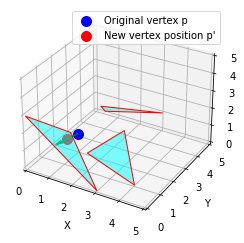

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 绘制图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三角面片
for key, tri in triangles.items():
    verts = [list(tri['vertices'])]
    tri_collection = Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5)
    ax.add_collection3d(tri_collection)


# Plot original and new vertices
ax.scatter(*p, color='blue', s=100, label='Original vertex p')
ax.scatter(*p_prime, color='red', s=100, label='New vertex position p\'')

# Draw an arrow from p to p_prime using quiver
ax.quiver(p[0], p[1], p[2], p_prime[0]-p[0], p_prime[1]-p[1], p_prime[2]-p[2], color='green', length=1.0, arrow_length_ratio=0.3, normalize=True)

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Set viewing limits
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])

# Show plot
plt.show()